In [493]:
import math

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

train_data = pd.read_csv('dataset/price_data_tr.csv')
heldout_data = pd.read_csv('dataset/price_data_val.csv')
test_data = pd.read_csv('dataset/price_data_ts.csv')

In [494]:
#print(train_data.shape) #(12968, 21)
#print(heldout_data.shape) #(4323, 21)
#print(test_data.shape) #(4322, 21)

# data.columns
# 'id', 'date', 
# 'price', 
# 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
# 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'

In [495]:
# 최신 연도로 바꾸고 기존 yr_bult, yr_renovated 삭제
train_data['yr_max'] = np.maximum(np.array(train_data.yr_built), np.array(train_data.yr_renovated))
train_data = train_data.drop(['yr_built','yr_renovated'], axis=1)

heldout_data['yr_max'] = np.maximum(np.array(heldout_data.yr_built), np.array(heldout_data.yr_renovated))
heldout_data = heldout_data.drop(['yr_built','yr_renovated'], axis=1)

test_data['yr_max'] = np.maximum(np.array(test_data.yr_built), np.array(test_data.yr_renovated))
test_data = test_data.drop(['yr_built','yr_renovated'], axis=1)

In [496]:
# -drop
train_data['zipcode'] = -train_data['zipcode']
heldout_data['zipcode'] = -heldout_data['zipcode']
test_data['zipcode'] = -test_data['zipcode']

In [497]:
e, pi, r2, re = math.e, math.pi, 2 ** 0.5, math.e ** 0.5

## apple lambda exp. for each features
# bathrooms
train_data['bathrooms'] = train_data['bathrooms'].apply(lambda x: x**r2)
# sqft_lot
train_data['sqft_lot'] = train_data['sqft_lot'].apply(lambda x: x**(1/pi))
# floors
train_data['floors'] = train_data['floors'].apply(lambda x: x**(1/(pi**pi)))
# waterfront
train_data['waterfront'] = train_data['waterfront'].apply(lambda x: x**(e**e))
# condition
train_data['condition'] = train_data['condition'].apply(lambda x: x**(pi**2))
# grade
train_data['grade'] = train_data['grade'].apply(lambda x: x**(re**re))
# sqft_basement
train_data['sqft_basement'] = train_data['sqft_basement'].apply(lambda x: x**(r2**r2))
# lat
train_data['lat'] = train_data['lat'].apply(lambda x: x**(1/(pi**pi)))
# sqft_lot15
train_data['sqft_lot15'] = train_data['sqft_lot15'].apply(lambda x: x**(1/pi))
# yr_max
train_data['yr_max'] = train_data['yr_max'].apply(lambda x: x**(e**2))


heldout_data['bathrooms'] = heldout_data['bathrooms'].apply(lambda x: x**r2)
heldout_data['sqft_lot'] = heldout_data['sqft_lot'].apply(lambda x: x**(1/pi))
heldout_data['floors'] = heldout_data['floors'].apply(lambda x: x**(1/(pi**pi)))
heldout_data['waterfront'] = heldout_data['waterfront'].apply(lambda x: x**(e**e))
heldout_data['condition'] = heldout_data['condition'].apply(lambda x: x**(pi**2))
heldout_data['grade'] = heldout_data['grade'].apply(lambda x: x**(re**re))
heldout_data['sqft_basement'] = heldout_data['sqft_basement'].apply(lambda x: x**(r2**r2))
heldout_data['lat'] = heldout_data['lat'].apply(lambda x: x**(1/(pi**pi)))
heldout_data['sqft_lot15'] = heldout_data['sqft_lot15'].apply(lambda x: x**(1/pi))
heldout_data['yr_max'] = heldout_data['yr_max'].apply(lambda x: x**(e**2))


test_data['bathrooms'] = test_data['bathrooms'].apply(lambda x: x**r2)
test_data['sqft_lot'] = test_data['sqft_lot'].apply(lambda x: x**(1/pi))
test_data['floors'] = test_data['floors'].apply(lambda x: x**(1/(pi**pi)))
test_data['waterfront'] = test_data['waterfront'].apply(lambda x: x**(e**e))
test_data['condition'] = test_data['condition'].apply(lambda x: x**(pi**2))
test_data['grade'] = test_data['grade'].apply(lambda x: x**(re**re))
test_data['sqft_basement'] = test_data['sqft_basement'].apply(lambda x: x**(r2**r2))
test_data['lat'] = test_data['lat'].apply(lambda x: x**(1/(pi**pi)))
test_data['sqft_lot15'] = test_data['sqft_lot15'].apply(lambda x: x**(1/pi))
test_data['yr_max'] = test_data['yr_max'].apply(lambda x: x**(e**2))

In [498]:
# normalize features and prices
nor_train = train_data.iloc[:, 3:].apply(lambda x: (x-x.mean()) / x.std())
nor_heldout = heldout_data.iloc[:, 3:].apply(lambda x: (x-x.mean()) / x.std())

nor_log_train_price = np.log(train_data.iloc[:, 2:3]).apply(lambda x: (x-x.mean()) / x.std())
nor_log_heldout_price = np.log(heldout_data.iloc[:, 2:3]).apply(lambda x: (x-x.mean()) / x.std())

nor_test = test_data.iloc[:, 3:].apply(lambda x: (x-x.mean()) / x.std())

In [499]:
# log(price) - mean, std for make predictions
train_log_label_mean, train_log_label_std = np.log(train_data['price']).mean(), np.log(train_data['price']).std()
print(train_log_label_mean, train_log_label_std)

heldout_log_label_mean, heldout_log_label_std = np.log(heldout_data['price']).mean(), np.log(heldout_data['price']).std()
print(heldout_log_label_mean, heldout_log_label_std)

uni_log_label_mean = np.log(pd.concat((train_data['price'], heldout_data['price']))).mean()
uni_log_label_std = np.log(pd.concat((train_data['price'], heldout_data['price']))).std()
print(uni_log_label_mean, uni_log_label_std)

13.04810655020148 0.5220080959315785
13.048257499579405 0.5355929705203868
13.048144289728448 0.5254218546587482


In [500]:
# numpy to tensor
train_feats = torch.tensor(nor_train.iloc[:, :].values, dtype=torch.float32)
heldout_feats = torch.tensor(nor_heldout.iloc[:, :].values, dtype=torch.float32)

train_labels = torch.tensor(nor_log_train_price.values.reshape(-1, 1), dtype=torch.float32)
heldout_labels = torch.tensor(nor_log_heldout_price.values.reshape(-1, 1), dtype=torch.float32)

test_feat = torch.tensor(nor_test.iloc[:, :].values, dtype=torch.float32)

In [501]:
n_train, in_features = train_data.shape[0], train_feats.shape[1]

class Regressor(nn.Module):
    def __init__(self):
        super(Regressor, self).__init__()
        self.fc1 = nn.Linear(in_features, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, 256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, 64)
        self.fc7 = nn.Linear(64, 32)
        self.fc8 = nn.Linear(32, 1)
        self.bn1 = nn.BatchNorm1d(32)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(128)
        self.bn4 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()

        
    def forward(self, x):
        x = self.dropout(self.relu(self.bn1(self.fc1(x))))
        x = self.dropout(self.relu(self.bn2(self.fc2(x))))
        x = self.dropout(self.relu(self.bn3(self.fc3(x))))
        x = self.dropout(self.relu(self.bn4(self.fc4(x))))
        x = self.dropout(self.relu(self.bn3(self.fc5(x))))
        x = self.relu(self.bn2(self.fc6(x)))
        x = self.relu(self.bn1(self.fc7(x)))
        x = self.fc8(x)
        return x
    
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [502]:
learning_rate = 0.001
weight_decay = 0.1
batch_size = 1024
epochs = 7000

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = Regressor().to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, 
                                                 milestones=[200,400,600,800,
                                                             1000,1200,1400,1600,1800,
                                                             2000,2200,2400,2600,2800,
                                                             3000,3200,3400,3600,3800,
                                                             4000,4200,4400,4600,4800,
                                                             5100,5400,5700,
                                                             6000,6300,6600,6900], 
                                                 gamma=0.85)

In [503]:
train_features, train_labels = train_feats.to(device), train_labels.to(device)
test_features, test_labels = heldout_feats.to(device), heldout_labels.to(device)

dataset = TensorDataset(train_features, train_labels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

train_ls, test_ls = [], []

for epoch in range(epochs):
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
    
    train_rmse = criterion(net(train_features), train_labels).item()
    test_rmse = criterion(net(test_features), test_labels).item()
    
    train_ls.append(train_rmse)
    test_ls.append(test_rmse)
    
    if test_rmse < 0.113:
        break
    
    if (epoch + 1) % 200 == 0:
        print(f'epoch: {epoch + 1} -- train_rmse: {train_rmse:.4f}, test_rmse: {test_rmse:.4f}')

epoch: 200 -- train_rmse: 0.1143, test_rmse: 0.1208
epoch: 400 -- train_rmse: 0.1123, test_rmse: 0.1231
epoch: 600 -- train_rmse: 0.1111, test_rmse: 0.1205
epoch: 800 -- train_rmse: 0.1112, test_rmse: 0.1228
epoch: 1000 -- train_rmse: 0.1113, test_rmse: 0.1206
epoch: 1200 -- train_rmse: 0.1082, test_rmse: 0.1194
epoch: 1400 -- train_rmse: 0.1091, test_rmse: 0.1224
epoch: 1600 -- train_rmse: 0.1083, test_rmse: 0.1184
epoch: 1800 -- train_rmse: 0.1096, test_rmse: 0.1228
epoch: 2000 -- train_rmse: 0.1101, test_rmse: 0.1249
epoch: 2200 -- train_rmse: 0.1084, test_rmse: 0.1221
epoch: 2400 -- train_rmse: 0.1075, test_rmse: 0.1216
epoch: 2600 -- train_rmse: 0.1067, test_rmse: 0.1218
epoch: 2800 -- train_rmse: 0.1076, test_rmse: 0.1212
epoch: 3000 -- train_rmse: 0.1073, test_rmse: 0.1224
epoch: 3200 -- train_rmse: 0.1081, test_rmse: 0.1195
epoch: 3400 -- train_rmse: 0.1079, test_rmse: 0.1221
epoch: 3600 -- train_rmse: 0.1058, test_rmse: 0.1208
epoch: 3800 -- train_rmse: 0.1062, test_rmse: 0.11

117590.0


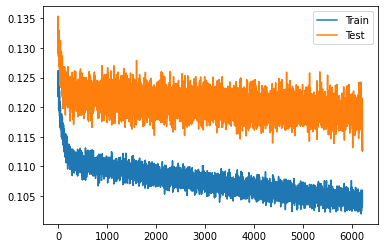

0.1060, 0.1126


In [504]:
predicts = net(train_features).to('cpu').detach().numpy()
uni_predicts = np.exp(predicts * train_log_label_std + train_log_label_mean)
train_labels_ = np.exp(train_labels.cpu() * train_log_label_std + train_log_label_mean)
print(rmse(uni_predicts, np.array(train_labels_)))

plt.plot(train_ls, label="Train")
plt.plot(test_ls, label="Test")
plt.legend()
plt.show()

print(f'{train_ls[-1]:0.4f}, {test_ls[-1]:0.4f}')

In [505]:
print(min(test_ls))

0.11264660954475403


In [506]:
trains = []
helds = []
unis = []

# averaging predictions
for i in range(3000):
    predicts = net(test_features).to('cpu').detach().numpy()

    train_predicts = np.exp(predicts * train_log_label_std + train_log_label_mean)
    held_predicts = np.exp(predicts * heldout_log_label_std + heldout_log_label_mean)
    uni_predicts = np.exp(predicts * uni_log_label_std + uni_log_label_mean)
        
    rmse_train = rmse(train_predicts, heldout_data.iloc[:, 2:3].values)
    rmse_held = rmse(held_predicts, heldout_data.iloc[:, 2:3].values)
    rmse_uni = rmse(uni_predicts, heldout_data.iloc[:, 2:3].values)
    
    trains.append(rmse_train)
    helds.append(rmse_held)
    unis.append(rmse_uni)

print(np.array(trains).mean())
print(np.array(helds).mean())
print(np.array(unis).mean())

# making final answer
finals = []

for i in range(3000):
    test_predicts = net(test_feat.to('cuda')).cpu().detach().numpy()
    final_predict = np.exp(test_predicts * uni_log_label_std + uni_log_label_mean)
    finals.append(final_predict)
np.array(finals).mean(axis = 0)

# 131588.9882797251
# 131751.391756751
# 131443.0004292868

136830.94335699466
138395.90243675615
137023.20984566875


array([[644666.44],
       [470956.2 ],
       [209384.02],
       ...,
       [868204.8 ],
       [557510.5 ],
       [411241.2 ]], dtype=float32)

In [ ]:
test_data = pd.read_csv('dataset/price_data_ts.csv')
test_data['price'] = np.array(finals).mean(axis = 0)

test_data['id'] = test_data['id'].apply(lambda x : str(x) if len(str(x)) == 10 else '0' + str(x) if len(str(x)) == 9 else '00' + str(x))
test_data['id'] = test_data['id'].astype(str) + test_data['date'].astype(str)
submission = pd.concat([test_data['id'], test_data['price']], axis=1)
submission

In [122]:
# making submission file
submission.to_csv('submission.csv', index=False)

In [173]:
# feature extractor + random forest regressor
def extract_middle(net, x):
    x = net.dropout(net.relu(net.fc1(x)))
    x = net.dropout(net.relu(net.fc2(x)))
    x = net.dropout(net.relu(net.fc3(x)))
    x = net.dropout(net.relu(net.fc4(x)))
    x = net.dropout(net.relu(net.fc5(x)))
    x = net.fc6(x)
    return x

In [174]:
train_feats.shape

torch.Size([12968, 17])

In [175]:
extract_middle(net, train_feats.to('cuda')).shape

torch.Size([12968, 64])

In [176]:
train_labels.flatten().shape

torch.Size([12968])

In [177]:
net = net.cuda() ; train_feats = train_feats.cuda()

In [178]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
model = RandomForestRegressor()
middle_value = extract_middle(net, train_feats)
middle_value = middle_value.cpu()
middle_value = middle_value.detach().numpy()

train_labels_cpu = train_labels.cpu()
train_labels_cpu = train_labels_cpu.detach().numpy()

model.fit(middle_value, train_labels_cpu.flatten())

RandomForestRegressor()

In [179]:
# val_labels_cpu = train_labels.cpu()
# val_labels_cpu = train_labels_cpu.detach().numpy()
middle_val = extract_middle(net, test_features)
middle_val = middle_val.cpu()
middle_val = middle_val.detach().numpy()

predicts = model.predict(middle_val)
train_predicts = np.exp(predicts * train_log_label_std + train_log_label_mean)
held_predicts = np.exp(predicts * heldout_log_label_std + heldout_log_label_mean)
uni_predicts = np.exp(predicts * uni_log_label_std + uni_log_label_mean)

tmse = np.sqrt(mean_squared_error(train_predicts, heldout_data.iloc[:, [2]].values))
hmse = np.sqrt(mean_squared_error(held_predicts, heldout_data.iloc[:, [2]].values))
umse = np.sqrt(mean_squared_error(uni_predicts, heldout_data.iloc[:, [2]].values))

print('평균제곱근오차', tmse)
print('평균제곱근오차', hmse)
print('평균제곱근오차', umse)

평균제곱근오차 181190.2087980236
평균제곱근오차 179051.13282611215
평균제곱근오차 180575.48078188335
